[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/machinelearnear/machinelearnear/large-scale-object-detection-with-sahi-detectron2/blob/main/quick-start.ipynb)

# Large Scale Object Detection Using SAHI and DETIC (Detectron2)

- Original Paper: "[Detic: Detecting 20K Classes Using Image-level Supervision](https://arxiv.org/abs/2201.02605)"
- https://github.com/facebookresearch/Detic
- https://github.com/obss/sahi

## Overview

Example using custom classes `['car','truck','automobile','sign','traffic light']`

![Large Scale Object Detection Using SAHI and Detectron2](example.png)

## Pre-requisites

### Install Detectron2

In [1]:
import torch, os
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  cu102


In [2]:
try:
    import detectron2
except ImportError:
    raise ImportError(
        "Please install detectron2. Check "
        "`https://detectron2.readthedocs.io/en/latest/tutorials/install.html` "
        "for installation details."
    )
    !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html -q

### Clone and install the Detic library

In [3]:
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules

fatal: destination path 'Detic' already exists and is not an empty directory.


In [ ]:
try: os.chdir("Detic")
except OSError: print("Dir has already been changed!")

## Configuration

In [5]:
from typing import Dict, List, Optional, Union

import numpy as np
import sys
import json, cv2, random
import requests
import time
from PIL import Image

from sahi.prediction import ObjectPrediction
from sahi.model import DetectionModel
from sahi.utils.compatibility import fix_full_shape_list, fix_shift_amount_list
from sahi.utils.cv import get_bbox_from_bool_mask, visualize_object_predictions
from sahi.utils.torch import cuda_is_available, empty_cuda_cache
from sahi.model import Detectron2DetectionModel
from sahi.predict import get_sliced_prediction, predict, get_prediction

## Build SAHI detector

### Custom Detectron2 Class

In [6]:
class Detectron2DeticModel(DetectionModel):
    def __init__(
        self,
        model_path: str,
        config_path: Optional[str] = None,
        device: Optional[str] = None,
        mask_threshold: float = 0.5,
        confidence_threshold: float = 0.3,
        category_mapping: Optional[Dict] = None,
        category_remapping: Optional[Dict] = None,
        load_at_init: bool = True,
        image_size: int = None,
        vocabulary: str = 'lvis',
        custom_classes: Optional[List] = None,
    ):
        """
        Init object detection/instance segmentation model.
        Args:
            model_path: str
                Path for the instance segmentation model weight
            config_path: str
                Path for the mmdetection instance segmentation model config file
            device: str
                Torch device, "cpu" or "cuda"
            mask_threshold: float
                Value to threshold mask pixels, should be between 0 and 1
            confidence_threshold: float
                All predictions with score < confidence_threshold will be discarded
            category_mapping: dict: str to str
                Mapping from category id (str) to category name (str) e.g. {"1": "pedestrian"}
            category_remapping: dict: str to int
                Remap category ids based on category names, after performing inference e.g. {"car": 3}
            load_at_init: bool
                If True, automatically loads the model at initalization
            image_size: int
                Inference input size.
            vocabulary: str
                Change to 'lvis', 'objects365', 'openimages', 'coco', or 'custom'
            custom_classes: list of str
                CLIP custom classes
        """
        self.model_path = model_path
        self.config_path = config_path
        self.model = None
        self.device = device
        self.mask_threshold = mask_threshold
        self.confidence_threshold = confidence_threshold
        self.category_mapping = category_mapping
        self.category_remapping = category_remapping
        self.image_size = image_size
        self._original_predictions = None
        self._object_prediction_list_per_image = None
        self.vocabulary = vocabulary
        self.custom_classes = custom_classes
        
       # automatically set device if its None
        if not (self.device):
            self.device = "cuda:0" if cuda_is_available() else "cpu"

        # automatically load model if load_at_init is True
        if load_at_init:
            self.load_model()
    
    def load_model(self):
        # import some common detectron2 utilities
        from detectron2 import model_zoo
        from detectron2.engine import DefaultPredictor
        from detectron2.config import get_cfg
        from detectron2.utils.visualizer import Visualizer
        from detectron2.data import MetadataCatalog, DatasetCatalog
        from detectron2.utils.logger import setup_logger
        setup_logger()
        
        # import dependencies needed by Detic
        sys.path.insert(0, 'third_party/CenterNet2/projects/CenterNet2/')
        from centernet.config import add_centernet_config
        from detic.config import add_detic_config
        from detic.modeling.utils import reset_cls_test

        cfg = get_cfg()
        add_centernet_config(cfg)
        add_detic_config(cfg)
        cfg.merge_from_file(self.config_path)
        cfg.MODEL.WEIGHTS = self.model_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = self.confidence_threshold  # set threshold for this model
        cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
        cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
        cfg.MODEL.DEVICE = self.device
        # init predictor
        self.model = DefaultPredictor(cfg)
        
        BUILDIN_CLASSIFIER = {
            'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
            'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
            'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
            'coco': 'datasets/metadata/coco_clip_a+cname.npy',
        }

        BUILDIN_METADATA_PATH = {
            'lvis': 'lvis_v1_val',
            'objects365': 'objects365_v2_val',
            'openimages': 'oid_val_expanded',
            'coco': 'coco_2017_val',
        }
        
        # setup the model's vocabulary using build-in datasets
        vocabulary = self.vocabulary
        if vocabulary == 'custom':
            if '__test' in([x for x in MetadataCatalog.keys()]): MetadataCatalog.pop('__test')
            metadata = MetadataCatalog.get("__test")
            metadata.thing_classes = self.custom_classes
            classifier = self.get_clip_embeddings(metadata.thing_classes)
            num_classes = len(metadata.thing_classes)
            reset_cls_test(self.model.model, classifier, num_classes)
            # Reset visualization threshold
            output_score_threshold = 0.5
            for cascade_stages in range(len(self.model.model.roi_heads.box_predictor)):
                self.model.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold
        else:
            metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
            classifier = BUILDIN_CLASSIFIER[vocabulary]
            num_classes = len(metadata.thing_classes)
            reset_cls_test(self.model.model, classifier, num_classes)
        
        # detectron2 category mapping
        if self.category_mapping is None:
            try:  # try to parse category names from metadata
                category_names = metadata.thing_classes
                self.category_names = category_names
                self.category_mapping = {
                    str(ind): category_name for ind, category_name in enumerate(self.category_names)
                }
            except Exception as e:
                logger.warning(e)
                # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#update-the-config-for-new-datasets
                if cfg.MODEL.META_ARCHITECTURE == "RetinaNet":
                    num_categories = cfg.MODEL.RETINANET.NUM_CLASSES
                else:  # fasterrcnn/maskrcnn etc
                    num_categories = cfg.MODEL.ROI_HEADS.NUM_CLASSES
                self.category_names = [str(category_id) for category_id in range(num_categories)]
                self.category_mapping = {
                    str(ind): category_name for ind, category_name in enumerate(self.category_names)
                }
        else:
            self.category_names = list(self.category_mapping.values())

    def get_clip_embeddings(self, vocabulary, prompt='a '):
        from detic.modeling.text.text_encoder import build_text_encoder
        text_encoder = build_text_encoder(pretrain=True)
        text_encoder.eval()
        texts = [prompt + x for x in vocabulary]
        emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
        return emb

    def perform_inference(self, image: np.ndarray, image_size: int = None):
        """
        Prediction is performed using self.model and the prediction result is set to self._original_predictions.
        Args:
            image: np.ndarray
                A numpy array that contains the image to be predicted. 3 channel image should be in RGB order.
        """
        try:
            import detectron2
        except ImportError:
            raise ImportError("Please install detectron2 via `pip install detectron2`")

        # confirm image_size is not provided
        if image_size is not None:
            warnings.warn("Set 'image_size' at DetectionModel init.")

        # Confirm model is loaded
        if self.model is None:
            raise RuntimeError("Model is not loaded, load it by calling .load_model()")

        if isinstance(image, np.ndarray) and self.model.input_format == "BGR":
            # convert RGB image to BGR format
            image = image[:, :, ::-1]

        prediction_result = self.model(image)

        self._original_predictions = prediction_result

    @property
    def num_categories(self):
        """
        Returns number of categories
        """
        num_categories = len(self.category_mapping)
        return num_categories

    def _create_object_prediction_list_from_original_predictions(
        self,
        shift_amount_list: Optional[List[List[int]]] = [[0, 0]],
        full_shape_list: Optional[List[List[int]]] = None,
    ):
        """
        self._original_predictions is converted to a list of prediction.ObjectPrediction and set to
        self._object_prediction_list_per_image.
        Args:
            shift_amount_list: list of list
                To shift the box and mask predictions from sliced image to full sized image, should
                be in the form of List[[shift_x, shift_y],[shift_x, shift_y],...]
            full_shape_list: list of list
                Size of the full image after shifting, should be in the form of
                List[[height, width],[height, width],...]
        """
        original_predictions = self._original_predictions
        category_mapping = self.category_mapping

        # compatilibty for sahi v0.8.15
        if isinstance(shift_amount_list[0], int):
            shift_amount_list = [shift_amount_list]
        if full_shape_list is not None and isinstance(full_shape_list[0], int):
            full_shape_list = [full_shape_list]

        # parse boxes, masks, scores, category_ids from predictions
        boxes = original_predictions["instances"].pred_boxes.tensor.tolist()
        scores = original_predictions["instances"].scores.tolist()
        category_ids = original_predictions["instances"].pred_classes.tolist()
        try:
            masks = original_predictions["instances"].pred_masks.tolist()
        except AttributeError:
            masks = None

        # create object_prediction_list
        num_categories = self.num_categories
        object_prediction_list_per_image = []
        object_prediction_list = []

        # detectron2 DefaultPredictor supports single image
        shift_amount = shift_amount_list[0]
        full_shape = None if full_shape_list is None else full_shape_list[0]

        for ind in range(len(boxes)):
            score = scores[ind]
            if score < self.confidence_threshold:
                continue

            category_id = category_ids[ind]

            if masks is None:
                bbox = boxes[ind]
                mask = None
            else:
                mask = np.array(masks[ind])

                # check if mask is valid
                if get_bbox_from_bool_mask(mask) is not None:
                    bbox = None
                else:
                    continue

            object_prediction = ObjectPrediction(
                bbox=bbox,
                bool_mask=mask,
                category_id=category_id,
                category_name=self.category_mapping[str(category_id)],
                shift_amount=shift_amount,
                score=score,
                full_shape=full_shape,
            )
            object_prediction_list.append(object_prediction)

        # detectron2 DefaultPredictor supports single image
        object_prediction_list_per_image = [object_prediction_list]

        self._object_prediction_list_per_image = object_prediction_list_per_image

### Load Detection model using pretrained weights

In [47]:
detection_model = Detectron2DeticModel(
    model_path='https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth',
    config_path='configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml',
    confidence_threshold=0.5,
    vocabulary='custom',
    custom_classes=['car','truck','automobile','sign','traffic light'],
    device="cuda",
)

01/29/2022 03:26:10 - INFO - fvcore.common.checkpoint -   [Checkpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...


Loading pretrained CLIP


## Run inference on test images

### Helper funcs

In [48]:
def download_image_from_url(image_url):
    res = requests.get(image_url, stream=True)
    return cv2.imdecode(np.asarray(bytearray(res.content)), 1)

def cv2_to_PIL(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

### Run inference

In [49]:
from pathlib import Path

In [50]:
# image_url = 'https://static1.hoy.es/www/pre2017/multimedia/noticias/201508/10/media/87373403.jpg'
# im = download_image_from_url(image_url)

In [51]:
test_images = [str(x) for x in Path('../test-images').glob('*.jpg')]
im = cv2.imread(test_images[0])

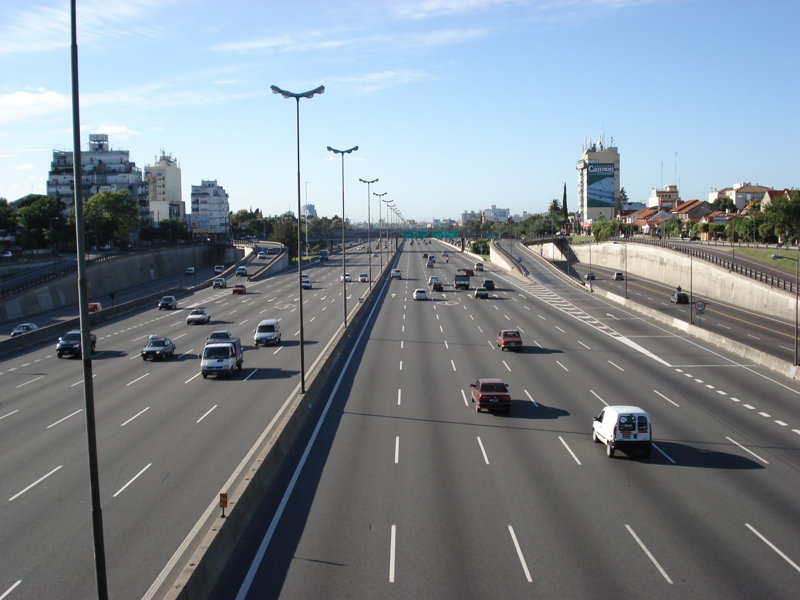

In [52]:
a = cv2_to_PIL(im)
a.thumbnail(size=(800,800))
a

### Get single prediction

In [53]:
elapsed_time = time.time()
result = get_prediction(
    im, 
    detection_model,
)
print(f'total time: {(time.time() - elapsed_time)*100:.2f} ms')

total time: 777.88 ms


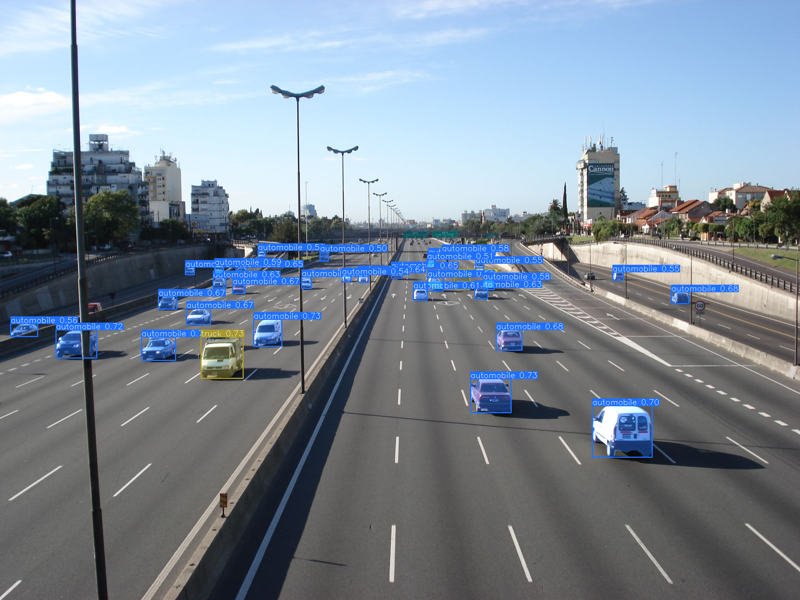

In [54]:
out = visualize_object_predictions(im, result.object_prediction_list)
out_img = cv2_to_PIL(out['image'])
out_img.thumbnail((800,800))
out_img

### Get sliced prediction

In [55]:
elapsed_time = time.time()
result = get_sliced_prediction(
    im,
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2,
)
print(f'total time: {(time.time() - elapsed_time)*100:.2f} ms')

Performing prediction on 80 number of slices.
total time: 2596.97 ms


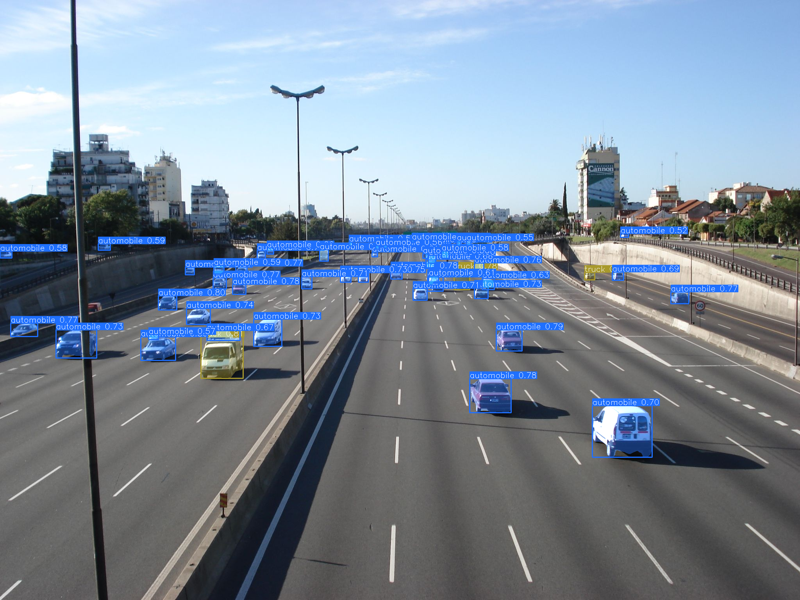

In [56]:
out = visualize_object_predictions(im, result.object_prediction_list)
out_img = cv2_to_PIL(out['image'])
out_img.thumbnail((800,800))
out_img

## Attribution
- `Ruta_Panamericana_Buenos_Aires_Florida.jpg` Arcibel, Public domain, via Wikimedia Commons
- `People_queue_to_leave_airport_20190812.jpg` Wpcpey, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons